In [23]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
from sklearn import svm, metrics, model_selection, linear_model
from datetime import date, timedelta
import datetime
import pytz

# Extraction of the data

In [24]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/'
daily='csse_covid_19_daily_reports/' #+date in the form  01-22-2020.csv
time_serie='csse_covid_19_time_series/' #+confirmed, death,recovered
confirmed_data='time_series_covid19_confirmed_global.csv'
death_data='time_series_covid19_deaths_global.csv'
recovered_data='time_series_covid19_recovered_global.csv'

In [25]:
confirmed=pd.read_csv(url+time_serie+confirmed_data)
dead=pd.read_csv(url+time_serie+death_data)
recovered=pd.read_csv(url+time_serie+recovered_data)

In [26]:
def make_date(a,b,c,d): 
    #convert a date in (day,month) format to a string to feed in the read_csv function
    day=str(a*10+b)
    month=str(10*c+d)
    if len(day)==1:
        day='0'+day
    if len(month)==1:
        month='0'+month 
    date=month+'-'+day+'-2020'
    return date
today = str(date.today())
a=int(today[5])
b=int(today[6])
c=int(today[8])
d=int(today[9])
today=make_date(c,d,a,b)
print(today)
def add_xday(a,b,c,d,x):
    day=c*10+d
    month=10*a+b
    if month==4 or month==6:
        endmonth=30
    else:
        endmonth=31
    newday=day+x
    if newday>endmonth:
        month+=1
        newday=newday-endmonth
        a=int(newday/10)
        b=newday-a
        
    return make_date(a,b,0,month)

def subdate (date):
    a=date[0]
    b=date[1]
    c=date[3]
    d=date[4]
    return '2020-'+a+b+'-'+c+d
print(subdate(today))
todayplus2=add_xday(a,b,c,d,2)
todayplusweek=add_xday(a,b,c,d,7)
print(today,todayplus2)

06-26-2020
2020-06-26
06-26-2020 06-06-2020


In [27]:
int(47/10)

4

In [28]:
#This cell save the data for the us in a dictionary us_data. Pay attention to adjuste to if statement to
#adjust it at the current date. The value of the dict are dataframe with: first ligne:confirme case, second: dead, 
#third: recovered. the columns are the different dates
us_data={}
total_state=[]
for month in range(1,7):
    for day in range(1,32):
        if month==1 and day<23:
            pass
        elif month==2 and day>29:
            pass
        elif month==4 and day>7:
            pass
        elif month==6 and day>9:
            pass
        else:
            a=int(day/10)
            dat=make_date(a,day-a*10,0,month)
            #print(dat)
            today_data=pd.read_csv(url+daily+dat+'.csv')
            if month<3 or (month==3 and day<22):
                st='Province/State'
                country='Country/Region'
            else:
                st='Province_State'
                country='Country_Region'
            for i, state in enumerate(today[st]):
                if today_data[country].iloc[i]!='US':
                    pass
                else:
                    if state not in total_state:
                        total_state.append(state)
                        us_data[state]=pd.DataFrame()
                        us_data[state][dat]=np.array([today_data['Confirmed'].iloc[i],today_data['Deaths'].iloc[i],today_data['Recovered'].iloc[i]])
                    elif dat not in us_data[state].columns:
                        us_data[state][dat]=np.array([today_data['Confirmed'].iloc[i],today_data['Deaths'].iloc[i],today_data['Recovered'].iloc[i]])
                    else:
                        us_data[state][dat]+=np.array([today_data['Confirmed'].iloc[i],today_data['Deaths'].iloc[i],today_data['Recovered'].iloc[i]])
                        
                    
  


TypeError: string indices must be integers

In [ ]:
# coronavirus progression plot for any state in the us: just pick one
state='New York'
time=np.arange(len(us_data[state].iloc[0,:]))
plt.figure()
plt.title('Coronavirus progression in '+state)
plt.xlabel('day after the first case ('+us_data[state].columns[0]+')')
plt.ylabel('number of case')
plt.plot(time,us_data[state].iloc[0,:],'b.',label='confirmed')
plt.plot(time,us_data[state].iloc[1,:],'r.',label='dead')
plt.plot(time,us_data[state].iloc[2,:],'g.',label='recovered')
plt.legend()
#plt.xlim()
plt.show()

# Data Exploration

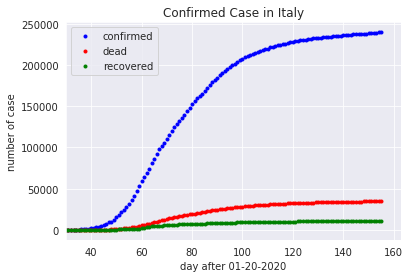

In [29]:
confirmed_italy=confirmed.iloc[137,4:]
dead_italy=dead.iloc[137,4:]
recovered_italy=recovered.iloc[137,4:]
confirmed_italy
time=np.arange(len(confirmed_italy))
plt.figure()
plt.title('Confirmed Case in Italy')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_italy,'b.',label='confirmed')
plt.plot(time,dead_italy,'r.',label='dead')
plt.plot(time,recovered_italy,'g.',label='recovered')
plt.legend()
plt.xlim(30)
plt.show()

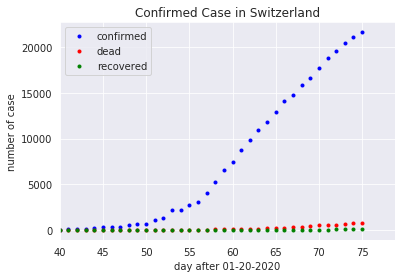

21657


In [65]:
l=80
confirmed_swiss=confirmed.iloc[206,4:l]
dead_swiss=dead.iloc[206,4:l]
recovered_swiss=recovered.iloc[206,4:l]
confirmed_swiss
time=np.arange(len(confirmed_swiss))
plt.figure()
plt.title('Confirmed Case in Switzerland')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_swiss,'b.',label='confirmed')
plt.plot(time,dead_swiss,'r.',label='dead')
plt.plot(time,recovered_swiss,'g.',label='recovered')
plt.legend()
plt.xlim(40)
plt.show()
print(confirmed_swiss[-1])

In [66]:
prediction_2days_swiss=pd.DataFrame()
print( todayplus2)
prediction_2days_swiss['Province/State']=[]
prediction_2days_swiss['Country']=['Switzerland']
prediction_2days_swiss['Target/Date']=[subdate(todayplus2)]
prediction_2days_swiss['N']=[0]
prediction_2days_swiss['R']=[0]
prediction_2days_swiss['D']=[0]

prediction_7days_swiss=pd.DataFrame()
prediction_7days_swiss['Province/State']=[]
prediction_7days_swiss['Country']=['Switzerland']
prediction_7days_swiss['Target/Date']=[subdate(todayplusweek)]
prediction_7days_swiss['N']=[0]
prediction_7days_swiss['R']=[0]
prediction_7days_swiss['D']=[0]

prediction_7days_swiss

06-06-2020


,Province/State,Country,Target/Date,N,R,D
0,NaN,Switzerland,2020-07-03,0,0,0


Contaminated Prediction for the next day in Switzerland

Method: using previous day to predict next: using the model on the last data point to predict tomorrow

# Training for Switzerland

In [ ]:
for i,s in enumerate(confirmed_swiss):
    if s==0:
        pass
    if s!=0:
        start=i
        break
#modelling for the swiss case
N=8.57*10**6
#start parameter
beta=1
gamma=1
S=[] #possible 
I=[] #infected
R=[] #removed (dead+cured)
for i in range (len(confirmed_swiss)):
    if i<start:
        pass
    else:
        I.append(confirmed_swiss[i])
        R.append(recovered_swiss[i]+dead_swiss[start])
        S.append(N-I[-1]-R[-1])
model=linear_model.Ridge()
X=pd.DataFrame()
X['St']=np.array(S[1:-2])
X['It']=np.array(I[1:-2])
X['Rt']=np.array(R[1:-2])
X['SI']=X['St']*X['It']
X_last_day=pd.DataFrame()
X_last_day['S']=np.array(S[-1:])
X_last_day['I']=np.array(I[-1:])
X_last_day['R']=np.array(R[-1:])
X_last_day['SI']=X_last_day['S']*X_last_day['I']
y=pd.DataFrame()
prediction_next_day=pd.DataFrame()
y['St+1']=np.array(S[2:-1])
y['It+1']=np.array(I[2:-1])
y['Rt+1']=np.array(R[2:-1])
X_betwenn=np.zeros((4,8))
for j in range(8):
    for i,col in enumerate(y.columns):
        model=linear_model.Ridge()
        model.fit(X,y[col])
        if j==0:
            X_betwenn[i,j]=model.predict((X_last_day))
            if i==2:
                X_betwenn[i+1,j]=X_betwenn[0,j]*X_betwenn[1,j]
        else:
            X_b=pd.DataFrame()
            X_b['S']=np.array([X_betwenn[0,j-1],X_betwenn[0,j-1]])
            X_b['I']=X_betwenn[1,j-1,...]
            X_b['R']=X_betwenn[2,j-1,...]
            X_b['SI']=X_betwenn[3,j-1,...]
            X_betwenn[i,j]=model.predict((X_b))[0]
            if i==2:
                X_betwenn[i+1,j]=X_betwenn[0,j]*X_betwenn[1,j]
print(X_betwenn[1,:])    
prediction_next_day[today]=X_betwenn[1,:]
print('prediction: ',prediction_next_day)
prediction_next_day.to_csv('prediction_nextday_swiss.csv')

In [71]:
##with dead as feature
print(today)
print(subdate(today))

for i,s in enumerate(confirmed_swiss):
    if s==0:
        pass
    if s!=0:
        start=i
        break
#modelling for the swiss case
N=8.57*10**6
#start parameter
beta=1
gamma=1
S=[] #possible 
I=[] #infected
R=[] #recovered
D=[]
DR=[]
for i in range (len(confirmed_swiss)):
    if i<start:
        pass
    else:
        I.append(confirmed_swiss[i])
        R.append(recovered_swiss[i])
        D.append(dead_swiss[i])
        DR.append(recovered_swiss[i]+dead_swiss[i])
        S.append(N-I[-1]-R[-1])
model=linear_model.Ridge()
X=pd.DataFrame()
X['St']=np.array(S[1:-2])
X['It']=np.array(I[1:-2])
X['Rt']=np.array(R[1:-2])
X['Dt']=np.array(D[1:-2])
X['DRt']=np.array(DR[1:-2])
X['SI']=X['St']*X['It']
X_last_day=pd.DataFrame()
X_last_day['S']=np.array(S[-1:])
X_last_day['I']=np.array(I[-1:])
X_last_day['R']=np.array(R[-1:])
X_last_day['D']=np.array(D[-1:])
X_last_day['DR']=np.array(DR[-1:])
X_last_day['SI']=X_last_day['S']*X_last_day['I']
y=pd.DataFrame()
prediction_next_day=pd.DataFrame()
y['St+1']=np.array(S[2:-1])
y['It+1']=np.array(I[2:-1])
y['Rt+1']=np.array(R[2:-1])
y['Dt+1']=np.array(D[2:-1])
X_betwenn=np.zeros((6,8))
score=[]
for j in range(8):
    for i,col in enumerate(y.columns):
        model=linear_model.Ridge(alpha=1000,normalize=False)
        model.fit(X,y[col])
        if j==0:
            X_betwenn[i,j]=model.predict((X_last_day))
            #score.append(model.score(X,y))
            if i==3:
                X_betwenn[i+1,j]=X_betwenn[2,j]+X_betwenn[3,j]
                X_betwenn[i+2,j]=X_betwenn[0,j]*X_betwenn[1,j]
        else:
            X_b=pd.DataFrame()
            X_b['S']=np.array([X_betwenn[0,j-1],X_betwenn[0,j-1]])
            X_b['I']=X_betwenn[1,j-1,...]
            X_b['R']=X_betwenn[2,j-1,...]
            X_b['D']=X_betwenn[3,j-1,...]
            X_b['DR']=X_betwenn[4,j-1,...]
            X_b['SI']=X_betwenn[5,j-1,...]
            X_betwenn[i,j]=model.predict((X_b))[0]
            if i==3:
                X_betwenn[i+1,j]=X_betwenn[2,j]+X_betwenn[3,j]
                X_betwenn[i+2,j]=X_betwenn[0,j]*X_betwenn[1,j]
print(X_betwenn[1,:])    
X_swiss=X_betwenn
prediction_2days_swiss['N']=int(X_betwenn[1,1])
prediction_2days_swiss['R']=int(X_betwenn[2,1])
prediction_2days_swiss['D']=int(X_betwenn[3,1])
prediction_7days_swiss['N']=int(X_betwenn[1,6])
prediction_7days_swiss['R']=int(X_betwenn[2,6])
prediction_7days_swiss['D']=int(X_betwenn[3,6])

prediction_2days_swiss.to_csv('S2day_prediction_'+subdate(today)+'.csv')
prediction_7days_swiss.to_csv('S7day_prediction_'+subdate(today)+'.csv')
subdate(today)

06-26-2020
2020-06-26


/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/pyth

[22151.15117253 22416.41931069 22440.01251645 22197.87125197
 21659.54458997 20790.75537954 19554.84025726 17913.65689136]


/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=5.96743e-21): result may not be accurate.
  overwrite_a=True).T
/home/okiss/anaconda3/lib/pyth

'2020-06-26'

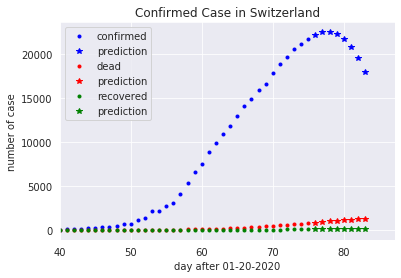

In [72]:
confirmed_swiss=confirmed.iloc[206,4:l]
dead_swiss=dead.iloc[206,4:l]
recovered_swiss=recovered.iloc[206,4:l]
confirmed_swiss
time=np.arange(len(confirmed_swiss))
new_time=np.arange(time[-1]+1,time[-1]+1+len(X_swiss[1,:]))
plt.figure()
plt.title('Confirmed Case in Switzerland')
plt.xlabel('day after 01-20-2020')
plt.ylabel('number of case')
plt.plot(time,confirmed_swiss,'b.',label='confirmed')
plt.plot(new_time,X_swiss[1,:],'b*',label='prediction')
plt.plot(time,dead_swiss,'r.',label='dead')
plt.plot(new_time,X_swiss[3,:],'r*',label='prediction')
plt.plot(time,recovered_swiss,'g.',label='recovered')
plt.plot(new_time,X_swiss[2,:],'g*',label='prediction')
plt.legend()
plt.xlim(40)
plt.show()

In [ ]:
Artemiy2=pd.read_csv('2Day_prediction_'+subdate(today)+'.csv')
Artemiy2=Artemiy2.replace(np.nan, '', regex=True)
Artemiy30=pd.read_csv('30Day_prediction_'+subdate(today)+'.csv')
Artemiy7=pd.read_csv('7Day_prediction_'+subdate(today)+'.csv')
Artemiy7=Artemiy7.replace(np.nan, '', regex=True)

Auriel2=pd.read_csv('S2day_prediction_'+subdate(today)+'.csv',index_col=0)
Auriel7=pd.read_csv('S7day_prediction_'+subdate(today)+'.csv',index_col=0)
Auriel2=Auriel2.replace(np.nan, '', regex=True)
Auriel7=Auriel7.replace(np.nan, '', regex=True)

Auriel2['Target/Date'].astype(str)
Auriel7['Target/Date'].astype(str)

Artemiy2['Target/Date'].astype(str)
Artemiy7['Target/Date'].astype(str)

Oriel2=pd.merge(Artemiy2,Auriel2)
Oriel7=pd.merge(Artemiy7,Auriel7)

Oriel2.to_csv('2day_prediction_'+subdate(today)+'.csv')
Oriel7.to_csv('7day_prediction_'+subdate(today)+'.csv')
Artemiy30.to_csv('30day_prediction_'+subdate(today)+'.csv')